In [1]:
from datetime import timedelta
import pandas as pd
pd.set_option('display.max_columns', 100)

In [52]:
Volatility_IDX_df = pd.read_csv('files/1.1-FTSE-IDX_VOL30-PRICES_2006-2023.csv')
day_trading = Volatility_IDX_df.loc[:,['Date']]
day_trading.Date = pd.to_datetime(day_trading.Date)
day_trading.loc[:, 'Month_Key'] = day_trading.Date.apply(lambda x: x.strftime('%Y-%m-01'))
day_trading.Month_Key = pd.to_datetime(day_trading.Month_Key)

In [53]:
date_list = []
for date in day_trading.Month_Key.unique():

    temp_df = day_trading[day_trading.Month_Key == date].copy()
    temp_df = temp_df.sort_values(by= 'Date', ascending=True)
    dt = temp_df.iloc[-1, 0]
    date_list.append(dt)

In [54]:
Volatility_IDX_df.Date = pd.to_datetime(Volatility_IDX_df.Date)

In [55]:
Volatility_IDX_df = Volatility_IDX_df.iloc[:,1: ]

In [56]:
Volatility_IDX_df = Volatility_IDX_df[Volatility_IDX_df.Date.isin(date_list)].iloc[2:]

In [58]:
Volatility_IDX_df.to_csv('files/1.1-FTSE-IDX_VOL30-MONTHLY-PRICES_2006-2023.csv')

# Merged DataFrames

## Volatility

In [4]:
volatility_df = pd.read_csv('files/1.1-FTSE_VOL30-PRICES_2006-2023.csv')
volatility_df.Date = pd.to_datetime(volatility_df.Date)
volatility_df.Asset = volatility_df.Asset.astype(int)

volatility_df.drop(['Month', 'Currency', 'PermID', 'Ticker', 'RIC', 'UnadjClose'], axis=1, inplace=True)

In [5]:
analysis_cols = ['Date','Asset', 'Open', 'High', 'Low', 'Close', 'Return', 'V^CC', 'V^RS', 'V^YZ']
vol_anly_df = volatility_df[analysis_cols]
vol_anly_df = vol_anly_df[vol_anly_df['V^YZ'].notnull()]
# vol_anly_df = vol_anly_df[vol_anly_df.Date < '2023-01-01']

### Filter-in last dates on each month

In [6]:
Monthly_Volatility_df = vol_anly_df[vol_anly_df.Date.isin(date_list)].reset_index(drop=True)

In [7]:
Monthly_Volatility_df.loc[:, 'month_key'] = Monthly_Volatility_df.Date.apply(lambda x: x.strftime('%Y-%m-01'))
Monthly_Volatility_df.month_key = pd.to_datetime(Monthly_Volatility_df.month_key)

Monthly_Volatility_df.month_key = Monthly_Volatility_df.month_key.apply(lambda x: x - timedelta(days=10))
Monthly_Volatility_df.loc[:, 'month_key'] = Monthly_Volatility_df.month_key.apply(lambda x: x.strftime('%Y-%m-01'))

Monthly_Volatility_df.month_key = pd.to_datetime(Monthly_Volatility_df.month_key)
Monthly_Volatility_df.index = Monthly_Volatility_df.month_key

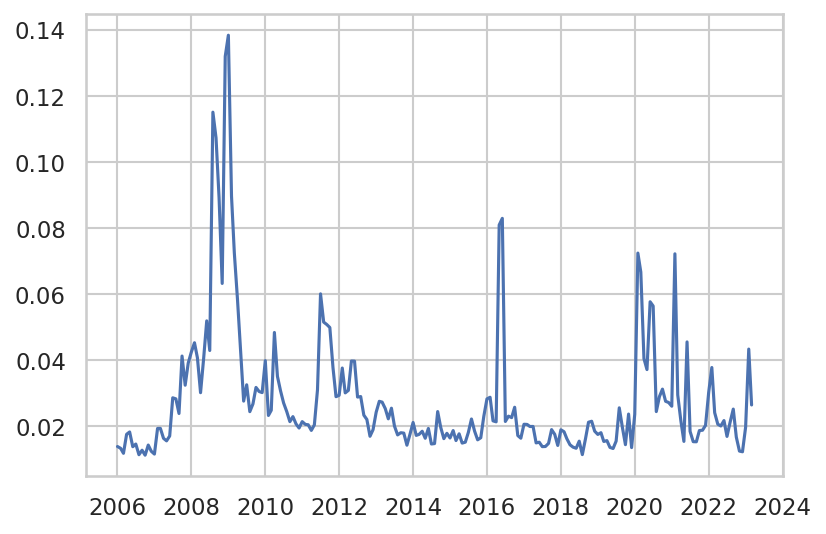

In [8]:
plt.plot(Monthly_Volatility_df[Monthly_Volatility_df.Asset == 8589934333]['V^YZ'])

### Filter-in last dates on each month

In [9]:
Monthly_Volatility_df.head(2)

,Date,Asset,Open,High,Low,Close,Return,V^CC,V^RS,V^YZ,month_key
month_key,,,,,,,,,,,
2006-01-01,2006-02-28,4295856631,9.374884,9.430687,9.263278,9.346983,-0.003964,0.009932,0.010240,0.011150,2006-01-01
2006-02-01,2006-03-31,4295856631,10.072421,10.100322,9.979416,9.998017,-0.002783,0.009381,0.008713,0.011151,2006-02-01


In [10]:
Monthly_Volatility_df = Monthly_Volatility_df[~(Monthly_Volatility_df.index.isin(['2006-01-01']))]

In [60]:
Monthly_Volatility_df.to_csv('files/1.1-FTSE_VOL30-MONTHLY-PRICES_2006-2023.csv', index=None)

## ESG Scores

In [11]:
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
pd.set_option('display.max_rows',30)
pd.set_option('display.max_rows', 150)

In [12]:
FTSE_ESG_Core = pd.read_csv('files/1.2-FTSE_ESG_COR_2006-2023.csv')

In [13]:
def filna_assets_df(df):

    Assets = df.Asset.unique()
    master_df = pd.DataFrame()

    for asset in Assets:
        temp_df = df[df['Asset'] == asset]
        all_nan_columns = temp_df.columns[temp_df.isna().all()].tolist()
        temp_df[all_nan_columns] = temp_df[all_nan_columns].fillna(0)
        missing_na_cols = temp_df.columns[temp_df.isna().any()]
        
        for col in missing_na_cols:
            mrows = temp_df[col].isna().sum() + 1
            # print(col, mrows)
            roll_mean = temp_df[col][::-1].rolling(window=mrows, min_periods=1).mean()
            temp_df[col] = temp_df[col].fillna(roll_mean)
            temp_df[col] = temp_df[col].fillna(method='ffill')

        temp_df = temp_df.reset_index(drop=True)
        master_df = pd.concat([master_df, temp_df])

    return master_df

In [14]:
FTSE_ESG_Core = filna_assets_df(FTSE_ESG_Core)

In [15]:
FTSE_ESG_Core.head(2)

,Asset,Date,windowTimestamp,buzz,ESG,ESGCombined,ESGControversies,EnvironmentalPillar,GovernancePillar,SocialPillar,CSRStrategy,Community,Emissions,EnvironmentalInnovation,HumanRights,Management,ProductResponsibility,ResourceUse,Shareholders,Workforce
0,4295856631,2006-01-01,2006-01-01 20:30:00+00:00,467.0,65.0,65.0,67.0,82.0,43.0,68.0,0.0,100.0,75.0,87.0,4.0,30.0,61.0,86.0,85.0,46.0
1,4295856631,2006-01-02,2006-01-02 20:30:00+00:00,467.0,65.0,65.0,67.0,82.0,43.0,68.0,0.0,100.0,75.0,87.0,4.0,30.0,61.0,86.0,85.0,46.0


In [16]:
FTSE_ESG_Core.Asset = FTSE_ESG_Core.Asset.astype(int)
FTSE_ESG_Core.Date = pd.to_datetime(FTSE_ESG_Core.Date)
FTSE_ESG_Core = FTSE_ESG_Core.drop(['windowTimestamp'], axis=1)
esg_core_cols = FTSE_ESG_Core.columns[2:].tolist()

In [17]:
Monthly_ESG_Core_Metrics = FTSE_ESG_Core[FTSE_ESG_Core.Date.isin(date_list)].reset_index(drop=True)

In [18]:
Monthly_ESG_Core_Metrics.head(2)

,Asset,Date,buzz,ESG,ESGCombined,ESGControversies,EnvironmentalPillar,GovernancePillar,SocialPillar,CSRStrategy,Community,Emissions,EnvironmentalInnovation,HumanRights,Management,ProductResponsibility,ResourceUse,Shareholders,Workforce
0,4295856631,2006-01-31,458.0,59.0,59.0,66.0,76.0,32.0,67.0,0.0,100.0,62.0,83.0,4.0,16.0,63.0,86.0,85.0,43.0
1,4295856631,2006-02-28,523.0,80.0,76.0,73.0,83.0,79.0,75.0,0.0,100.0,66.0,89.0,4.0,84.0,94.0,95.0,60.0,40.0


In [19]:
Monthly_ESG_Core_Metrics['month_key'] = Monthly_ESG_Core_Metrics.Date.apply(lambda x: x + timedelta(days=10))

In [20]:
Monthly_ESG_Core_Metrics.month_key = Monthly_ESG_Core_Metrics.month_key.apply(lambda x: x.strftime('%Y-%m-01'))

---

In [21]:
# column month_key on esg_core dataframe is + 1 month to help the dataframe merge.
print('FTSE ESG News MarketPsych Min Date:', Monthly_ESG_Core_Metrics.month_key.min())
print('FTSE ESG News MarketPsych Max Date:', Monthly_ESG_Core_Metrics.month_key.max())

FTSE ESG News MarketPsych Min Date: 2006-02-01
FTSE ESG News MarketPsych Max Date: 2023-05-01


In [22]:
print('FTSE Volatility Min Date:', Monthly_Volatility_df.month_key.min())
print('FTSE Volatility Max Date:', Monthly_Volatility_df.month_key.max())

FTSE Volatility Min Date: 2006-02-01 00:00:00
FTSE Volatility Max Date: 2023-03-01 00:00:00


---

In [23]:
Monthly_ESG_Core_Metrics = Monthly_ESG_Core_Metrics[Monthly_ESG_Core_Metrics.month_key < '2023-01-01']

In [24]:
Monthly_Volatility_df = Monthly_Volatility_df[Monthly_Volatility_df.month_key < '2023-01-01']

---

In [25]:
# column month_key on esg_core dataframe is + 1 month to help the dataframe merge.
print('FTSE ESG News MarketPsych Min Date:', Monthly_ESG_Core_Metrics.month_key.min())
print('FTSE ESG News MarketPsych Max Date:', Monthly_ESG_Core_Metrics.month_key.max())

FTSE ESG News MarketPsych Min Date: 2006-02-01
FTSE ESG News MarketPsych Max Date: 2022-12-01


In [26]:
print('FTSE Volatility Min Date:', Monthly_Volatility_df.month_key.min())
print('FTSE Volatility Max Date:', Monthly_Volatility_df.month_key.max())

FTSE Volatility Min Date: 2006-02-01 00:00:00
FTSE Volatility Max Date: 2022-12-01 00:00:00


---

In [27]:
Monthly_ESG_Core_Metrics.month_key = pd.to_datetime(Monthly_ESG_Core_Metrics.month_key)

In [28]:
Monthly_Volatility_df = Monthly_Volatility_df.reset_index(drop=True)

In [29]:
merge_all_df = pd.merge(Monthly_Volatility_df,Monthly_ESG_Core_Metrics, how = 'left', on = ['month_key', 'Asset'])

In [30]:
merge_all_df

,Date_x,Asset,Open,High,Low,Close,Return,V^CC,V^RS,V^YZ,month_key,Date_y,buzz,ESG,ESGCombined,ESGControversies,EnvironmentalPillar,GovernancePillar,SocialPillar,CSRStrategy,Community,Emissions,EnvironmentalInnovation,HumanRights,Management,ProductResponsibility,ResourceUse,Shareholders,Workforce
0,2006-03-31,4295856631,10.072421,10.100322,9.979416,9.998017,-0.002783,0.009381,0.008713,0.011151,2006-02-01,2006-01-31,458.0,59.0,59.0,66.0,76.0,32.0,67.0,0.000000,100.0,62.0,83.0,4.0,16.000000,63.0,86.0,85.0,43.000000
1,2006-04-28,4295856631,10.490942,10.546745,10.342134,10.379336,-0.012389,0.008596,0.007716,0.009801,2006-03-01,2006-02-28,523.0,80.0,76.0,73.0,83.0,79.0,75.0,0.000000,100.0,66.0,89.0,4.0,84.000000,94.0,95.0,60.0,40.000000
2,2006-05-31,4295856631,10.137524,10.137524,9.914312,9.914312,-0.030909,0.014678,0.010464,0.013490,2006-04-01,2006-03-31,509.0,74.0,73.0,72.0,76.0,82.0,60.0,0.000000,100.0,45.0,93.0,4.0,90.000000,86.0,95.0,55.0,5.000000
3,2006-06-30,4295856631,10.137524,10.230529,10.063120,10.230529,0.028037,0.016566,0.010636,0.014731,2006-05-01,2006-04-28,523.0,63.0,63.0,69.0,74.0,78.0,40.0,0.000000,100.0,47.0,87.0,4.0,85.000000,88.0,90.0,53.0,12.000000
4,2006-07-31,4295856631,10.109622,10.128223,10.025918,10.100322,0.003697,0.013617,0.008261,0.011834,2006-06-01,2006-05-31,505.0,64.0,64.0,66.0,77.0,77.0,41.0,0.000000,100.0,69.0,81.0,4.0,83.000000,91.0,82.0,57.0,12.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19254,2022-10-31,5081488120,2.704998,2.729500,2.650999,2.680000,-0.004827,0.017351,0.018508,0.020788,2022-09-01,2022-08-31,154.5,44.0,25.0,6.0,30.0,49.0,78.0,47.000000,78.0,39.0,1.0,0.0,72.833333,1.0,19.0,49.0,7.333333
19255,2022-11-30,5081488120,2.842998,2.858499,2.795000,2.840999,-0.004381,0.012695,0.020143,0.019944,2022-10-01,2022-09-30,361.0,49.0,30.0,12.0,27.0,76.0,47.0,45.479167,91.0,45.0,1.0,0.0,74.000000,1.0,18.0,81.0,7.854167
19256,2022-12-30,5081488120,3.289998,3.323499,3.273499,3.273499,0.001376,0.012671,0.015879,0.021473,2022-11-01,2022-10-31,378.0,48.0,30.0,13.0,25.0,74.0,47.0,48.177215,91.0,40.0,2.0,0.0,71.000000,2.0,19.0,82.0,8.886076
19257,2023-01-31,5081488120,3.180000,3.345000,3.147500,3.242500,0.010755,0.014676,0.014254,0.015070,2022-12-01,2022-11-30,424.5,44.0,31.0,18.0,29.0,72.0,33.0,54.926606,93.0,36.0,39.0,0.0,68.000000,2.0,19.0,84.0,8.000000


In [31]:
cols = ['Date_x',
'month_key',
'Asset',
'Open',
'High',
'Low',
'Close',
'Return',
'buzz',
'ESG',
'ESGCombined',
'ESGControversies',
'EnvironmentalPillar',
'GovernancePillar',
'SocialPillar',
'CSRStrategy',
'Community',
'Emissions',
'EnvironmentalInnovation',
'HumanRights',
'Management',
'ProductResponsibility',
'ResourceUse',
'Shareholders',
'Workforce',
'V^CC',
'V^RS',
'V^YZ']

In [32]:
merge_all_df = merge_all_df[cols]

In [33]:
merge_all_df.isna().sum()

Date_x                       0
month_key                    0
Asset                        0
Open                         0
High                         0
Low                          0
Close                        0
Return                       0
buzz                       308
ESG                        308
ESGCombined                308
ESGControversies           308
EnvironmentalPillar        308
GovernancePillar           308
SocialPillar               308
CSRStrategy                308
Community                  308
Emissions                  308
EnvironmentalInnovation    308
HumanRights                308
Management                 308
ProductResponsibility      308
ResourceUse                308
Shareholders               308
Workforce                  308
V^CC                         0
V^RS                         0
V^YZ                         0
dtype: int64

In [34]:
merge_all_df[merge_all_df['Asset'] == 4295894186]

,Date_x,month_key,Asset,Open,High,Low,Close,Return,buzz,ESG,ESGCombined,ESGControversies,EnvironmentalPillar,GovernancePillar,SocialPillar,CSRStrategy,Community,Emissions,EnvironmentalInnovation,HumanRights,Management,ProductResponsibility,ResourceUse,Shareholders,Workforce,V^CC,V^RS,V^YZ
415,2006-03-31,2006-02-01,4295894186,2.839998,2.844998,2.779998,2.829998,-0.000883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018582,0.019121,0.020331
416,2006-04-28,2006-03-01,4295894186,2.992498,3.004998,2.967498,2.977498,-0.005013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014803,0.017931,0.018218
417,2006-05-31,2006-04-01,4295894186,2.719998,2.912498,2.719998,2.897498,0.053635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024055,0.021935,0.023230
418,2006-06-30,2006-05-01,4295894186,2.857498,2.927498,2.812500,2.844998,0.009760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022489,0.019949,0.022858
419,2006-07-31,2006-06-01,4295894186,2.939998,2.979998,2.924998,2.944998,-0.004227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012291,0.015207,0.016903
420,2006-08-31,2006-07-01,4295894186,3.157498,3.177498,3.139998,3.174998,0.011147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012838,0.012572,0.014177
421,2006-09-29,2006-08-01,4295894186,3.127498,3.144998,3.117498,3.129998,0.005622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012849,0.012198,0.013123
422,2006-10-31,2006-09-01,4295894186,3.319998,3.375000,3.319998,3.347498,-0.002235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013827,0.014068,0.015595
423,2006-11-30,2006-10-01,4295894186,3.422498,3.467498,3.377498,3.392498,-0.013092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013813,0.017538,0.019861
424,2006-12-29,2006-11-01,4295894186,3.822498,3.837498,3.799998,3.817498,-0.003914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019069,0.016159,0.017657


In [35]:
merge_all_fill_df = filna_assets_df(merge_all_df)

In [36]:
merge_all_fill_df[merge_all_fill_df['Asset'] == 4295894186].head(15)

,Date_x,month_key,Asset,Open,High,Low,Close,Return,buzz,ESG,ESGCombined,ESGControversies,EnvironmentalPillar,GovernancePillar,SocialPillar,CSRStrategy,Community,Emissions,EnvironmentalInnovation,HumanRights,Management,ProductResponsibility,ResourceUse,Shareholders,Workforce,V^CC,V^RS,V^YZ
0,2006-03-31,2006-02-01,4295894186,2.839998,2.844998,2.779998,2.829998,-0.000883,2.000000,24.571429,24.571429,87.571429,24.571429,44.982829,49.279415,0.0,46.734847,24.571429,38.641096,0.0,35.066861,41.750000,33.630137,48.852676,0.0,0.018582,0.019121,0.020331
1,2006-04-28,2006-03-01,4295894186,2.992498,3.004998,2.967498,2.977498,-0.005013,2.500000,25.375000,25.375000,88.625000,23.625000,44.247121,49.494488,0.0,47.267991,23.625000,38.641096,0.0,35.033845,41.750000,33.630137,48.119067,0.0,0.014803,0.017931,0.018218
2,2006-05-31,2006-04-01,4295894186,2.719998,2.912498,2.719998,2.897498,0.053635,4.222222,27.444444,26.111111,81.000000,25.111111,43.523526,49.661767,0.0,47.571548,25.111111,38.641096,0.0,35.008167,42.888889,33.666881,47.405718,0.0,0.024055,0.021935,0.023230
3,2006-06-30,2006-05-01,4295894186,2.857498,2.927498,2.812500,2.844998,0.009760,6.800000,29.700000,28.400000,77.800000,27.600000,42.883432,49.695590,0.0,47.214393,26.800000,40.676986,0.0,34.987624,44.600000,35.300193,46.720307,0.0,0.022489,0.019949,0.022858
4,2006-07-31,2006-06-01,4295894186,2.939998,2.979998,2.924998,2.944998,-0.004227,9.272727,31.454545,30.272727,75.727273,29.545455,42.316568,49.541446,0.0,46.831266,28.454545,41.979078,0.0,34.970817,45.636364,36.545630,46.071178,0.0,0.012291,0.015207,0.016903
5,2006-08-31,2006-07-01,4295894186,3.157498,3.177498,3.139998,3.174998,0.011147,11.333333,32.666667,31.583333,74.000000,31.000000,41.813772,49.079659,0.0,46.095328,29.750000,42.647489,0.0,34.956810,46.333333,37.500161,45.447305,0.0,0.012838,0.012572,0.014177
6,2006-09-29,2006-08-01,4295894186,3.127498,3.144998,3.117498,3.129998,0.005622,13.000000,33.615385,32.615385,72.615385,32.000000,41.426985,48.842762,0.0,45.934149,30.692308,42.828451,0.0,34.944959,46.692308,38.153995,44.919412,0.0,0.012849,0.012198,0.013123
7,2006-10-31,2006-09-01,4295894186,3.319998,3.375000,3.319998,3.347498,-0.002235,14.428571,34.142857,33.214286,71.500000,32.571429,41.120096,48.496850,0.0,45.581709,31.285714,42.840705,0.0,34.934800,46.714286,38.142995,44.466932,0.0,0.013827,0.014068,0.015595
8,2006-11-30,2006-10-01,4295894186,3.422498,3.467498,3.377498,3.392498,-0.013092,15.666667,34.266667,33.400000,70.466667,32.733333,40.863065,47.863727,0.0,45.076262,31.400000,42.517991,0.0,34.925996,46.333333,38.000129,44.074784,0.0,0.013813,0.017538,0.019861
9,2006-12-29,2006-11-01,4295894186,3.822498,3.837498,3.799998,3.817498,-0.003914,16.750000,34.250000,33.437500,69.625000,32.750000,40.632698,47.122244,0.0,44.446496,31.375000,42.110616,0.0,34.918293,45.750000,37.750121,43.731653,0.0,0.019069,0.016159,0.017657


In [37]:
merge_all_fill_df.isna().sum()

Date_x                     0
month_key                  0
Asset                      0
Open                       0
High                       0
Low                        0
Close                      0
Return                     0
buzz                       0
ESG                        0
ESGCombined                0
ESGControversies           0
EnvironmentalPillar        0
GovernancePillar           0
SocialPillar               0
CSRStrategy                0
Community                  0
Emissions                  0
EnvironmentalInnovation    0
HumanRights                0
Management                 0
ProductResponsibility      0
ResourceUse                0
Shareholders               0
Workforce                  0
V^CC                       0
V^RS                       0
V^YZ                       0
dtype: int64

In [38]:
merge_all_fill_df.to_csv('files/1.3-FTSE_Monthly_ESG_Volatility_Final.csv', index=None)